In [523]:
%matplotlib inline
import numpy as np
import pandas as pd

## Read

In [524]:
data = pd.read_csv('yelp_2k.csv')
data.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vVXQrmj6CArpQJkJQ_4fMQ,DgvO50NfNIEZeinKkCgORA,-XrG8PgkJ4XehqWOnV1-TA,1,2017-08-20,This car wash sucks. Paid $40 for the Ultimat...,0,0,0
1,pkcT55BnL6JsZlz4H0CpBw,E7xztB1S0evVyjG38WSfow,tktorxzEnFYEXE5CkQTP4A,5,2015-04-19,I was referred to Earnie by friends and since ...,0,0,0
2,z-GV4ZfqLGTjbVr2QfPj8A,G73QCz-7EOEKAyJ6cGnjkg,RSSZt1bcFHbvYYTI2he6lg,1,2017-08-14,"The food is okay, but they have the worst serv...",0,0,0
3,BXrlwetTFhEMm3uq_cddsQ,gAcz_T0JKVmXDWkFehJigQ,VzSUgIOcyO7JmTwYDnyivQ,1,2012-02-06,Opting out from the noise and hustle of Flo's ...,7,8,1
4,Jh59oT1TdLzO_XPcfHzeRQ,emeP3q1wBsmZDa3ZkRC8ug,fKlr9qNoV37WQJwQ826POg,5,2015-07-19,"Basically, unlimited steak. If you like steak,...",3,0,0


## Bag of words

In [525]:
from sklearn.feature_extraction.text import CountVectorizer

# stop words: list of str
vectorizer = CountVectorizer(lowercase=True, stop_words=None)
X = vectorizer.fit_transform(data.text)

# data stars to binary 1 -> 0, 5->1
y = data.stars.copy()
y[data.stars ==1] = 0
y[data.stars ==5] =1

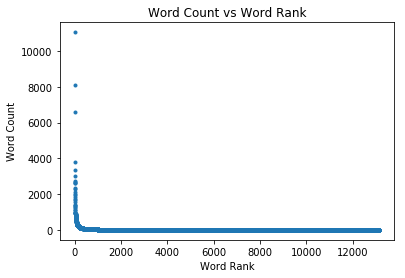

In [526]:
import matplotlib.pyplot as plt

words_count = np.sum(X.toarray(),0)
plt.plot(sorted(words_count, reverse=True), '.')
plt.title('Word Count vs Word Rank')
plt.xlabel('Word Rank')
plt.ylabel('Word Count')
plt.show()

### Stop Words

In [551]:
words = pd.DataFrame([vectorizer.get_feature_names(), list(words_count)]).T
words.columns= ['word', 'count']

# minimum word count:1
min_words = words[words['count']<5].word
max_words = words[words['count']>1000].word

# stop words
# exclude numbers and weird words
num_list = list(words[words.word.str.contains('[0-9]')].word)
for_list = list(words[words.word.str.contains('[äçü]')].word)

### Updated

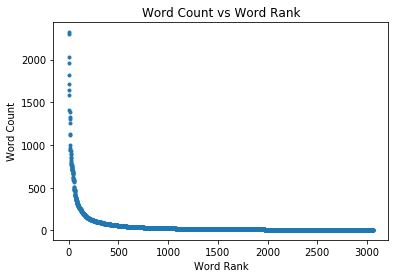

In [553]:
n = data.shape[0]
vectorizer = CountVectorizer(stop_words=num_list+for_list, min_df=5/n, max_df=1000/n)
X = vectorizer.fit_transform(data.text)

words_count = np.sum(X.toarray(), 0)
plt.plot(sorted(words_count, reverse=True), '.')
plt.title('Word Count vs Word Rank')
plt.xlabel('Word Rank')
plt.ylabel('Word Count')
plt.show()

## Text Retrieval

In this section, we look at finding similar documents to a query phrase.

1. Using nearest neighbor with a cos-distance metric, find 5 reviews matching *Horrible customer service.*
2. Print the original text from the review along with the associated distance score. You can truncate the review to 200 words so we don't get a page of text.
3. Looking at all the distance scores, how many documents do you think are good matches to the query?

In [555]:
'service' in vectorizer.get_feature_names()

True

In [576]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5, metric = 'cosine')
knn.fit(X, y)
text_x = vectorizer.transform(['horrible customer service'])
dist_arr, idx = knn.kneighbors(text_x, n_neighbors=30)

In [579]:
for i, dist in enumerate(dist_arr[0]):
    print(i)
    print(data.text[idx[0][i]])
    print('cosine distance: '+str(1-dist) )
    print('\n')

0
Rogers ...

1) is over priced
2) have horrible customer service
3) faulty and incorrect billing
4) poor customer service
5) not enough options
6) never arrive for an appointment
cosine distance: 0.6154574548966637


1
Horrible service, horrible customer service, and horrible quality of service!  Do not waste your time or money using this company for your pool needs.  Dan (602)363-8267 broke my pool filtration system and left it in a nonworking condition.  He will not repair the issue he caused, and told me to go somewhere else.  

Save yourself the hassle, there are plenty of other quality pool companies out there.  

Take care!
cosine distance: 0.45184805705753206


2
Service was horrible came with a major attitude. Payed 30 for lasagna and was no where worth it. Won't ever be going back and will NEVER recommend this place. was treated absolutely horrible. Horrible.
cosine distance: 0.4364357804719847


3
Went to Marca today to get a haircut and was given a great service both by fro

## Classification with Logistic Regression

In [447]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# train test split 0.1
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1)
logit = LogisticRegression()
logit.fit(train_X, train_y)
pred = logit.predict(test_X)
# test set accuracy
logit.score(test_X, test_y)

0.95

In [626]:
# train set accuracy
logit.score(train_X, train_y)

1.0

In [627]:
## divide pos and neg
neg_mask = np.where(train_y==0)
pos_mask = np.where(train_y==1)

# neg, pos split
train_negX = train_X[neg_mask]
train_posX = train_X[pos_mask]

# prob for each neg, pos
neg_prob = logit.predict_proba(train_negX)[:,1]
pos_prob = logit.predict_proba(train_posX)[:,1]

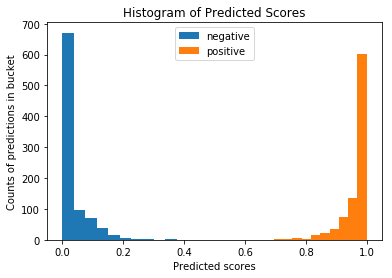

In [628]:
# plot hist
plt.hist(neg_prob, bins=10)
plt.hist(pos_prob, bins=10)
plt.title('Histogram of Predicted Scores')
plt.ylabel('Counts of predictions in bucket')
plt.xlabel('Predicted scores')
plt.legend(['negative', 'positive'], loc=9)
# plt.ylim([0,5])
plt.show()

### New Threshold

In [629]:
# test set
threshold = 0.4
pred = test_y.copy()
pred[:]= 0
pred[logit.predict_proba(test_X)[:,1]>threshold] = 1

np.mean(pred==test_y)

0.96

In [630]:
# train set
pred = train_y.copy()
pred[:]= 0
pred[logit.predict_proba(train_X)[:,1]>threshold] = 1

np.mean(pred==train_y)

1.0

## ROC curve

In [619]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# calculate prob
prob = logit.predict_proba(test_X)
# get false positive, true positive
fpr, tpr, thresholds = roc_curve(y_true=test_y, y_score=prob[:,1])

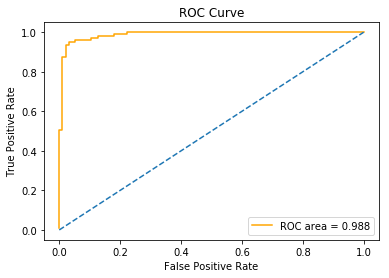

In [621]:
plt.plot(fpr, tpr, color='orange', label= '')
plt.plot([0,1], '--')
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['ROC area = {0:0.3f}'.format(auc(fpr, tpr))])
plt.show()

In [641]:
roc_data = pd.DataFrame([fpr, tpr, np.round(thresholds,2)]).T
roc_data.columns = ['False Positive', 'True Positive', "Thresholds"]

In [642]:
roc_data

,False Positive,True Positive,Thresholds
0,0.000000,0.009524,1.00
1,0.000000,0.504762,0.98
2,0.010526,0.504762,0.98
3,0.010526,0.876190,0.71
4,0.021053,0.876190,0.70
5,0.021053,0.933333,0.54
6,0.031579,0.933333,0.52
7,0.031579,0.952381,0.43
8,0.052632,0.952381,0.36
9,0.052632,0.961905,0.36


In [644]:
roc_data['distance'] = roc_data.iloc[:,0]+(1-roc_data.iloc[:,1])
roc_data

,False Positive,True Positive,Thresholds,distance
0,0.000000,0.009524,1.00,0.990476
1,0.000000,0.504762,0.98,0.495238
2,0.010526,0.504762,0.98,0.505764
3,0.010526,0.876190,0.71,0.134336
4,0.021053,0.876190,0.70,0.144862
5,0.021053,0.933333,0.54,0.087719
6,0.031579,0.933333,0.52,0.098246
7,0.031579,0.952381,0.43,0.079198
8,0.052632,0.952381,0.36,0.100251
9,0.052632,0.961905,0.36,0.090727
